## Introduction

I was thinking for a while about my master thesis topic and I wanted it was related to data mining and artificial intelligence because I want to learn more about this field. I want to work with machine learning and for that, I have to study it more. Writing a thesis is a great way to get more experience with it. <br>
I thought I will use this dataset as a part of my thesis topic.


### Machine learning in medicine
This field of study takes a more and more important role in our life. AI helps not only in the IT section but also in medicine. It supports doctors, farceurs, helps with validating data about patients, and even helps with diagnosing disease. <br><br>
**In this kernel we will try to:**
* Analise data of patients with heart problems. 
* Find what plays a key role in causing heart disease
* Process data 
* And make a prediction model



### Dataset explenation
* age: The person's age in years
* sex: The person's sex (1 = male, 0 = female)
* cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: * asymptomatic)
* trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
* chol: The person's cholesterol measurement in mg/dl
* fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
* restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or * definite left ventricular hypertrophy by Estes' criteria)
* thalach: The person's maximum heart rate achieved
* exang: Exercise induced angina (1 = yes; 0 = no)
* oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
* slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
* ca: The number of major vessels (0-3)
* thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
* target: Heart disease (0 = no, 1 = yes)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pdpbox import pdp, info_plots
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math


In [2]:

dataset = pd.read_csv('Data/heart.csv')
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### That's how our dataset looks like

# Analysing data

We will start with small changes in our dataset so we can better understand what is going on on the plots.

In [3]:
dt = dataset.copy()  # make copy of dataset

dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['cp'][dt['cp'] == 0] = 'typical angina'
dt['cp'][dt['cp'] == 1] = 'atypical angina'
dt['cp'][dt['cp'] == 2] = 'non-anginal pain'
dt['cp'][dt['cp'] == 3] = 'asymptomatic'

dt['slope'][dt['slope'] == 0] = 'upsloping'
dt['slope'][dt['slope'] == 1] = 'flat'
dt['slope'][dt['slope'] == 2] = 'downsloping'

dt['target'][dt['target'] == 0] = 'healthy'
dt['target'][dt['target'] == 1] = "sick"

In [4]:
dt.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,asymptomatic,145,233,1,0,150,0,2.3,upsloping,0,1,sick
1,37,male,non-anginal pain,130,250,0,1,187,0,3.5,upsloping,0,2,sick
2,41,female,atypical angina,130,204,0,0,172,0,1.4,downsloping,0,2,sick
3,56,male,atypical angina,120,236,0,1,178,0,0.8,downsloping,0,2,sick
4,57,female,typical angina,120,354,0,1,163,1,0.6,downsloping,0,2,sick


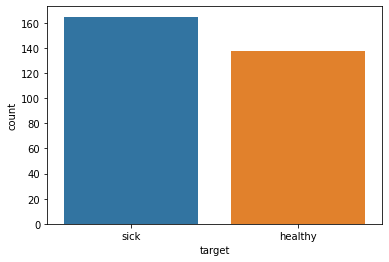

In [5]:
countplot = sns.countplot(x='target', data=dt)


We can see our data is more-less balanced. Now let's check how many rows we have in our dataset.

In [6]:
dt['age'].size

303

### 303 rows

It might be enough for studying machine learning and data visualization - which means it suits our needs. However, it's not enough to fully analyze heart disease and make a prediction model with at least 95% accuracy.

We can start with checking if in our dataset gender has some impact on disease

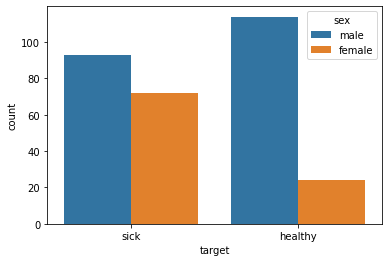

In [7]:
sns.countplot(x='target', hue='sex', data=dt)

Looks a bit odd. More male is in both groups which can mean there is much more male in our dataset than female. Let's check it out.

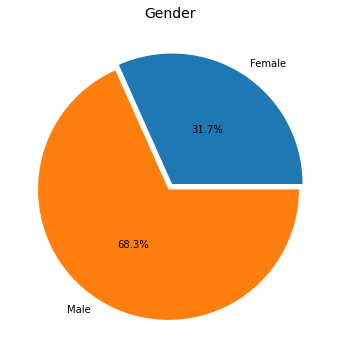

In [8]:
pie, ax = plt.subplots(figsize=[10,6])
data = dt.groupby("sex").size()  # data for Pie chart
labels = ['Female', 'Male']
plt.pie(x=data, autopct="%.1f%%", explode=[0.025]*2,labels=labels, pctdistance=0.5)
plt.title("Gender", fontsize=14);

Yes, as I thought the majority of people in this dataset are male. From what we can read on the internet mostly men suffer from heart disease which may explain why we have in dataset more men. Next we will take a look on a age.

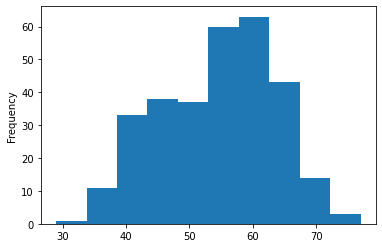

In [9]:
dt["age"] = dt["age"].astype(float)
dt["age"].plot.hist()

In [10]:
dt["age"].mean() # the age mean

54.366336633663366

Clearly, most patients in the dataset are people older than 50 years old. The mean is 54 years old. Which isn't anything surprising. Mostly older people have problems with the heart. What is more interesting is the number of people age above 65 years old. However, it's just a small dataset so we cannot be sure why there are fewer people who are very old (65 years old and more)

## Chest Pain Type Analysis


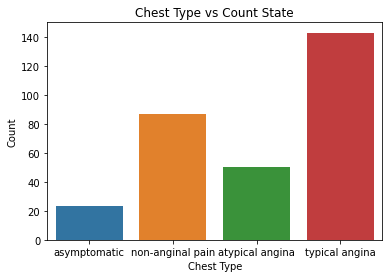

In [11]:
sns.countplot(dt['cp'])
plt.xlabel('Chest Type')
plt.ylabel('Count')
plt.title('Chest Type vs Count State')
plt.show()

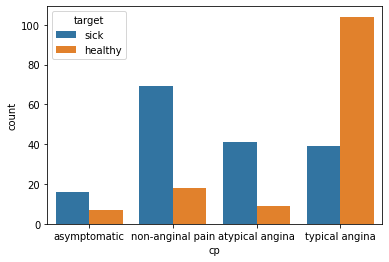

In [12]:
sns.countplot(x="cp", hue="target", data=dt)

In this plot, I divide data into 4 groups depending on the type of chest pain and compare it to target (is patient healthy or not)
<br>
We can see that above 100 people with **typical angina** pain are healthy. And on the other side, the major of people with **non-anginal pain** have heart disease<br><br><br>


To do that we will need create a model. This time we will use **Random Forest** with depth 3. We don't have many cases so we cannot use higher depth. I'm still not sure if there will not be any **overfit**.

In [37]:
X = dataset.drop("target", axis=1) # X = all data apart of survived column
y = dataset["target"] # y = only column survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model_RFC = RandomForestClassifier(max_depth=3)
model_RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=3)

<br><br>
Now I'm going to use **Partial Dependence Plot**. It's something I just learned so let's try it out.

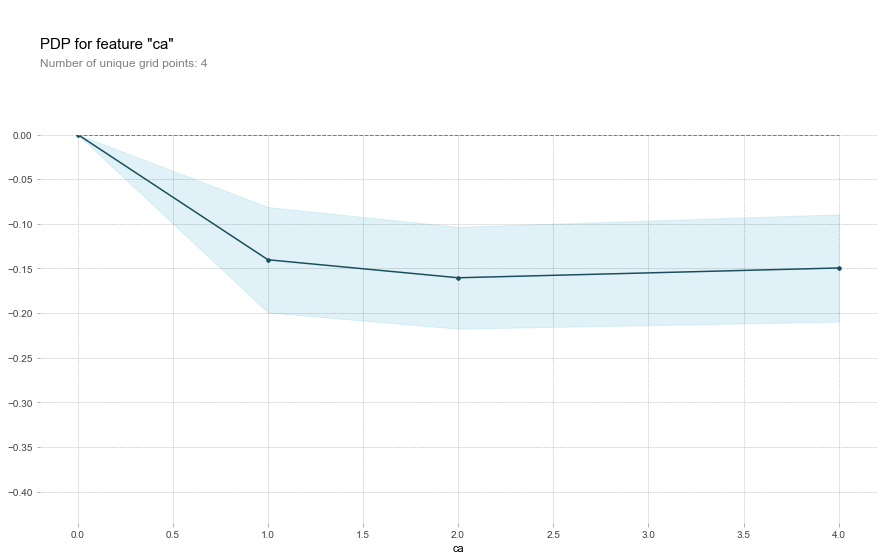

In [38]:
base_features = dataset.columns.values.tolist()
base_features.remove('target')

nr_of_vessles = dataset.columns.values.tolist()
nr_of_vessles.remove('target')

# ca - number of major vessels
pdp_dist = pdp.pdp_isolate(model=model_RFC, dataset=X_test, model_features=base_features, feature='ca')

pdp.pdp_plot(pdp_dist, 'ca')
plt.show()

### Result of Partial Dependence Plot on 'ca' value

We see that line drops down when number of 'ca' increase but what does it mean? <br> It means that when number of major blood vessels **increases**, the probability of heart disease **decrease**.

## Let's build a Logistic Regression model as well
and check **confusion matrix** and accuracy for both models

In [44]:
model_lr = LogisticRegression()
model_lr.fit(X_train,y_train)

LogisticRegression()

In [47]:
# confusion matrix for random forest
prediction = model_RFC.predict(X_test)
confusion_matrix(y_test, prediction)

acc = model_RFC.score(X_test,y_test)*100
print("Accuracy of Random Forest = ", acc);

Accuracy of Random Forest =  86.88524590163934


In [46]:
prediction = model_lr.predict(X_test)
confusion_matrix(y_test, prediction)

acc = model_lr.score(X_test,y_test)*100
print("Accuracy of Logistic Regression= ", acc);

Accuracy of Logistic Regression=  85.24590163934425


### From the result we can see **Random Forest** model has a bit better result. Its accuracy is better by 1.6%
Later I'll continue analising this dataset and I'm going to check other predictin models and find out which one has the best result